### Naive Bayes classifier with Laplacian smoothing: spam-filtering

- donat un atribut discret $X^j\in\,\vec{X}$ tal que $X^j = \{x^j_1,x^j_2,\dots, x^j_l\}$ (és a dir, amb $l$ categories):

$$
\forall x^j_k\in X^{j},\,\forall c\in Y,\; P\left(X^{j} = x^{j}_k\,|\,Y=c\right) = \frac{n^{j}_{k|c} +\alpha}{\sum_{k=1}^{l}\,\left(n^{j}_{k|c} \,+\,\alpha\right)}
$$

- $\alpha$ és el paràmetre de *smoothing*, generalment considerem $\alpha = 1$

- ajuda a "generalitzar" la mostra

- assigna una probabilitat diferent de zero a les combinacions $\left(x^j_k, c\right)$ que no estan representades en la mostra (o sigui que $n^j_{k|c} = 0$)

- com més gran sigui $\alpha$ més dispersem la densitat de probabilitat ($\approxeq$ *bandwidth* en les variables contínues)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

#### Example: Naiva Bayes classifier for spam filtering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/M03_notebooks/SMSSpamCollection'

In [ ]:
df = pd.read_csv(file_path, header=None, sep='\t', names=['Label', 'SMS'])

In [ ]:
df.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


##### tokenize messages

In [ ]:
import string

In [ ]:
def tokenize(message):
    for p in string.punctuation:
        message = message.replace(p, ' ')
    return message.lower().split()

In [ ]:
df['tokens'] = df.SMS.apply(tokenize)

##### train/test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2873)

##### build dictionary from train dataset

In [ ]:
dictionary = {word: {'ham': 0, 'spam': 0} for word in list(set(X_train['tokens'].sum()))}
len(dictionary)

7884

In [ ]:
def count_words(message):
    for word in message.tokens:
      dictionary[word][message.Label] +=1

_ = X_train.apply(count_words, axis = 1)

##### compute likelihood functions

In [ ]:
# total number of words in HAM messages
n_ham = sum([counts['ham'] for word, counts in dictionary.items()])
n_ham

57342

Per cada paraula haurem de mirar el likelyhood i per fer això haurem de mirar quants cops apareix i dividir per el total de paraules que tenen la etiqueta spam/ham.

In [ ]:
# total number of words in SPAM messages
n_spam = sum([counts['spam'] for word, counts in dictionary.items()])
n_spam

14814

Aquí fem un laplace smoothing amb la alpha. Al Notebook anterior està explicat també això del smoothing que es no creure's totes les dades del principi, no suposem que són una súper mostra que representa al 100% les dades.
<br/>
Per no estar recalculant tot el rato el diccionari ho fem amb la formula aquesta de N1 + len(dict) * alplha

In [ ]:
def ham_word_likelihood(word, alpha):
    if word in dictionary:
        return (dictionary[word]['ham'] + alpha) /(n_ham +(len(dictionary) *alpha))
    else:
        # Si la paraula no existeix, deixem la 'posterior' s'ha de quedar igual. per tant multipliquem per 1.
        return 1

In [ ]:
def spam_word_likelihood(word, alpha):
    if word in dictionary:
        return (dictionary[word]['spam'] + alpha) /(n_spam +(len(dictionary) *alpha))
    else:
        return 1

#### prior

Això estaría bé fer-ho amb un diccinoari bé si en tinguessim moltes, però en aquest cas de només dos ja està bé així. Es refereix a això: `post_ham, post_spam = prior` a dins de la funció `def classify(message, alpha):`

In [ ]:
prior = X_train.Label.value_counts(normalize = True)
prior

ham     0.869195
spam    0.130805
Name: Label, dtype: float64

In [ ]:
  post_ham, post_spam = prior
  print(post_ham)

0.8691945254655598


#### posterior

In [ ]:
def classify(tokens, alpha):
    post_ham, post_spam = prior
    for word in tokens:
        post_ham *= ham_word_likelihood(word, alpha)
        post_spam *= spam_word_likelihood(word, alpha)
    return 'spam' if post_spam > post_ham else ('ham' if post_ham > post_spam else '??')

##### classify with smoothing parameter $\alpha$

In [ ]:
alpha = 1 # Si ho posem amb 1, surt millor
X_test['predicted'] = X_test.tokens.apply(lambda x: classify(x, alpha))

In [ ]:
X_test.head()

,Label,SMS,tokens,predicted
4062,ham,"Aight I've been set free, think you could text...","[aight, i, ve, been, set, free, think, you, co...",ham
494,ham,What class of &lt;#&gt; reunion?,"[what, class, of, lt, gt, reunion]",ham
1396,ham,Thats cool! I am a gentleman and will treat yo...,"[thats, cool, i, am, a, gentleman, and, will, ...",ham
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,"[your, next, amazing, xxx, picsfree1, video, w...",ham
3120,ham,Stop knowing me so well!,"[stop, knowing, me, so, well]",ham


In [ ]:
pd.concat((X_test.groupby('Label').predicted.value_counts(), X_test.groupby('Label').predicted.value_counts(normalize = True)), axis = 1)

predicted  predicted
Label predicted                      
ham   ham              946   0.994742
      spam               4   0.004206
      ??                 1   0.001052
spam  spam             153   0.932927
      ham               11   0.067073

Tenim molts no classificats per que no fem el laplacing smoothing

In [ ]:
import random

random_keys = random.sample(dictionary.keys(), 100)
random_records = {key: dictionary[key] for key in random_keys}

df = pd.DataFrame(random_records).T

# Sense fer-ho amb random:
# df = pd.DataFrame(dictionary).T.head(100)

<ipython-input-64-8ce1db4ca17d>:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_keys = random.sample(dictionary.keys(), 100)


In [ ]:
df.head(2)

,ham,spam
freemsg,0,9
cds,0,3


In [ ]:
# Apliquem alpha per veure les diferencies del laplace smoothing
alpha = 5
#alpha = 100
df['ham'] += alpha
df['spam'] += alpha

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


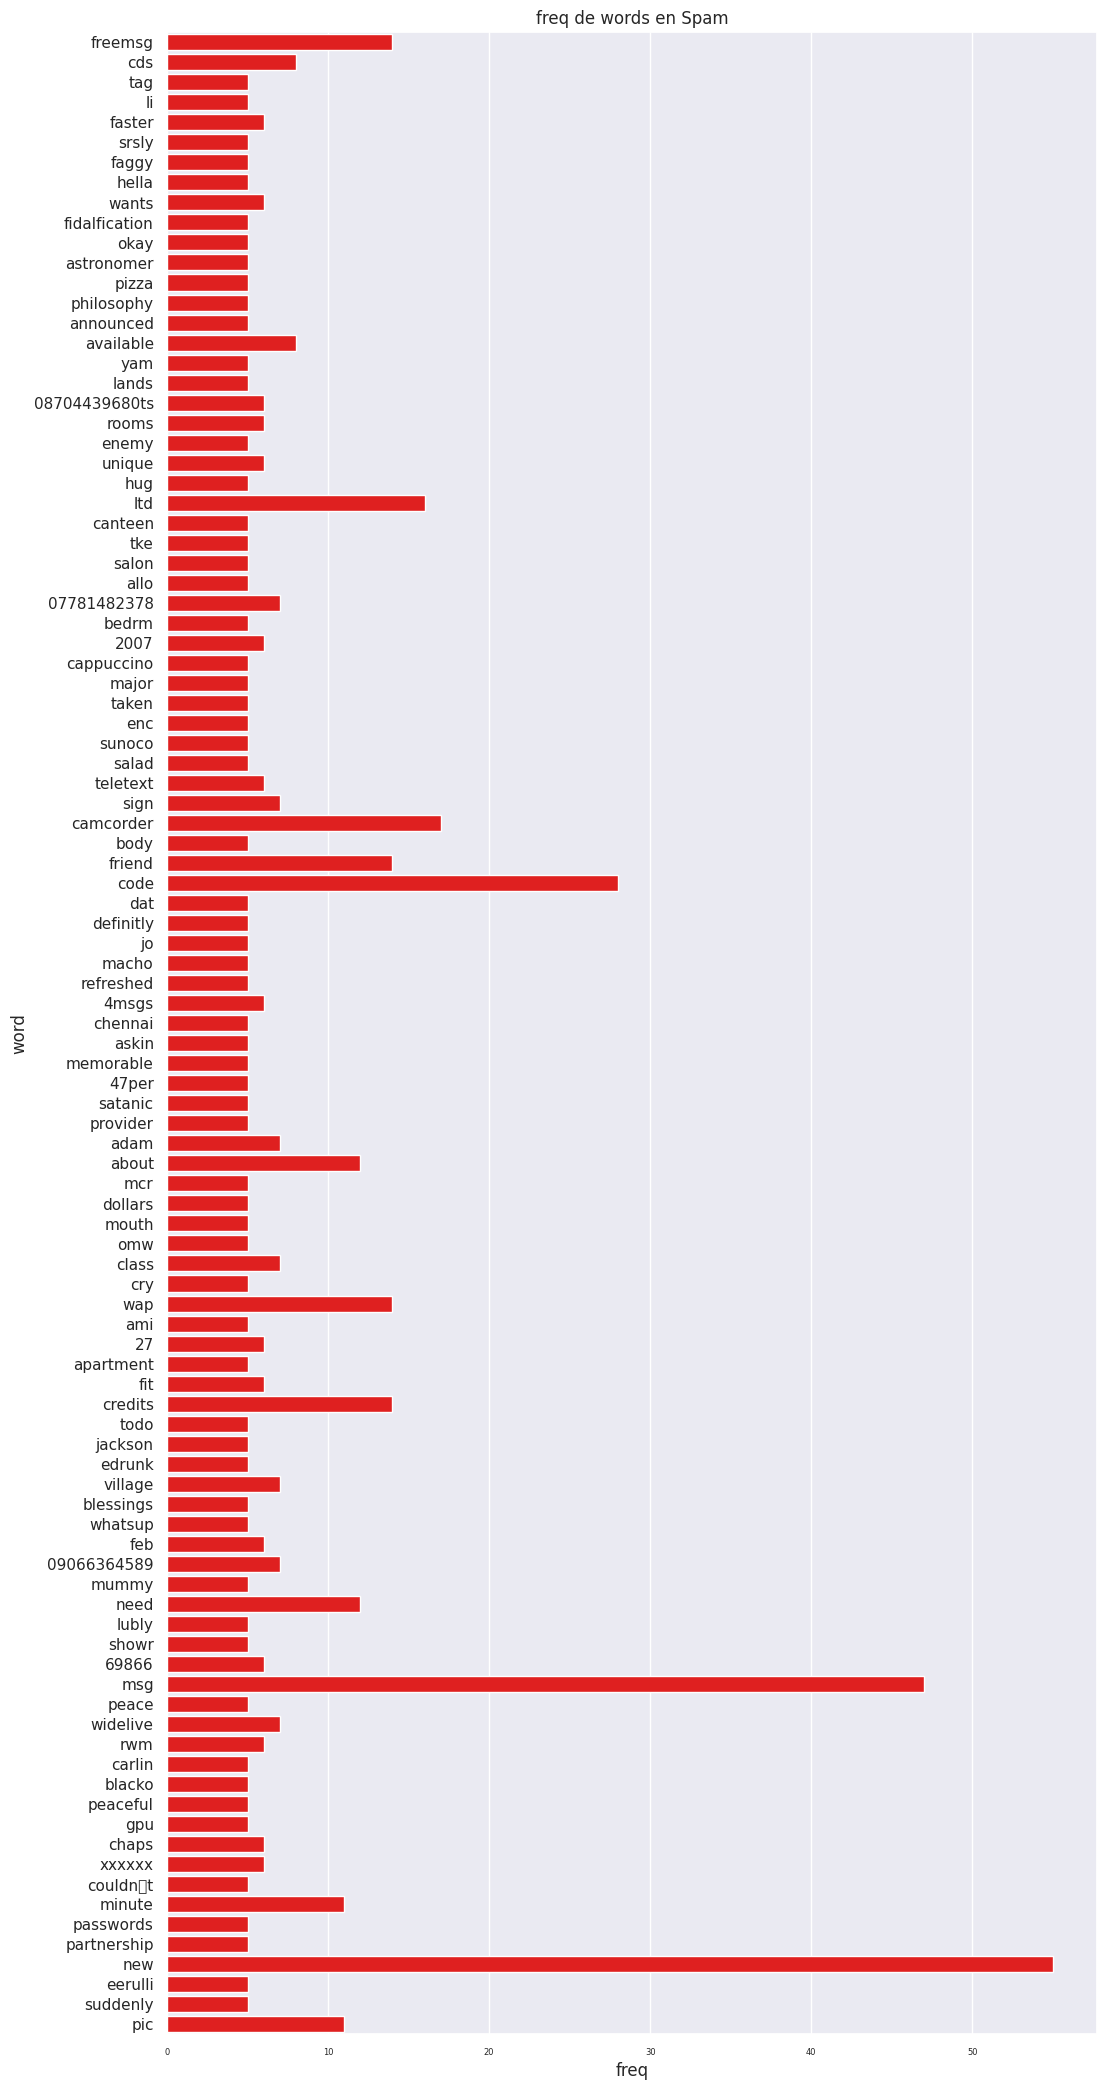

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


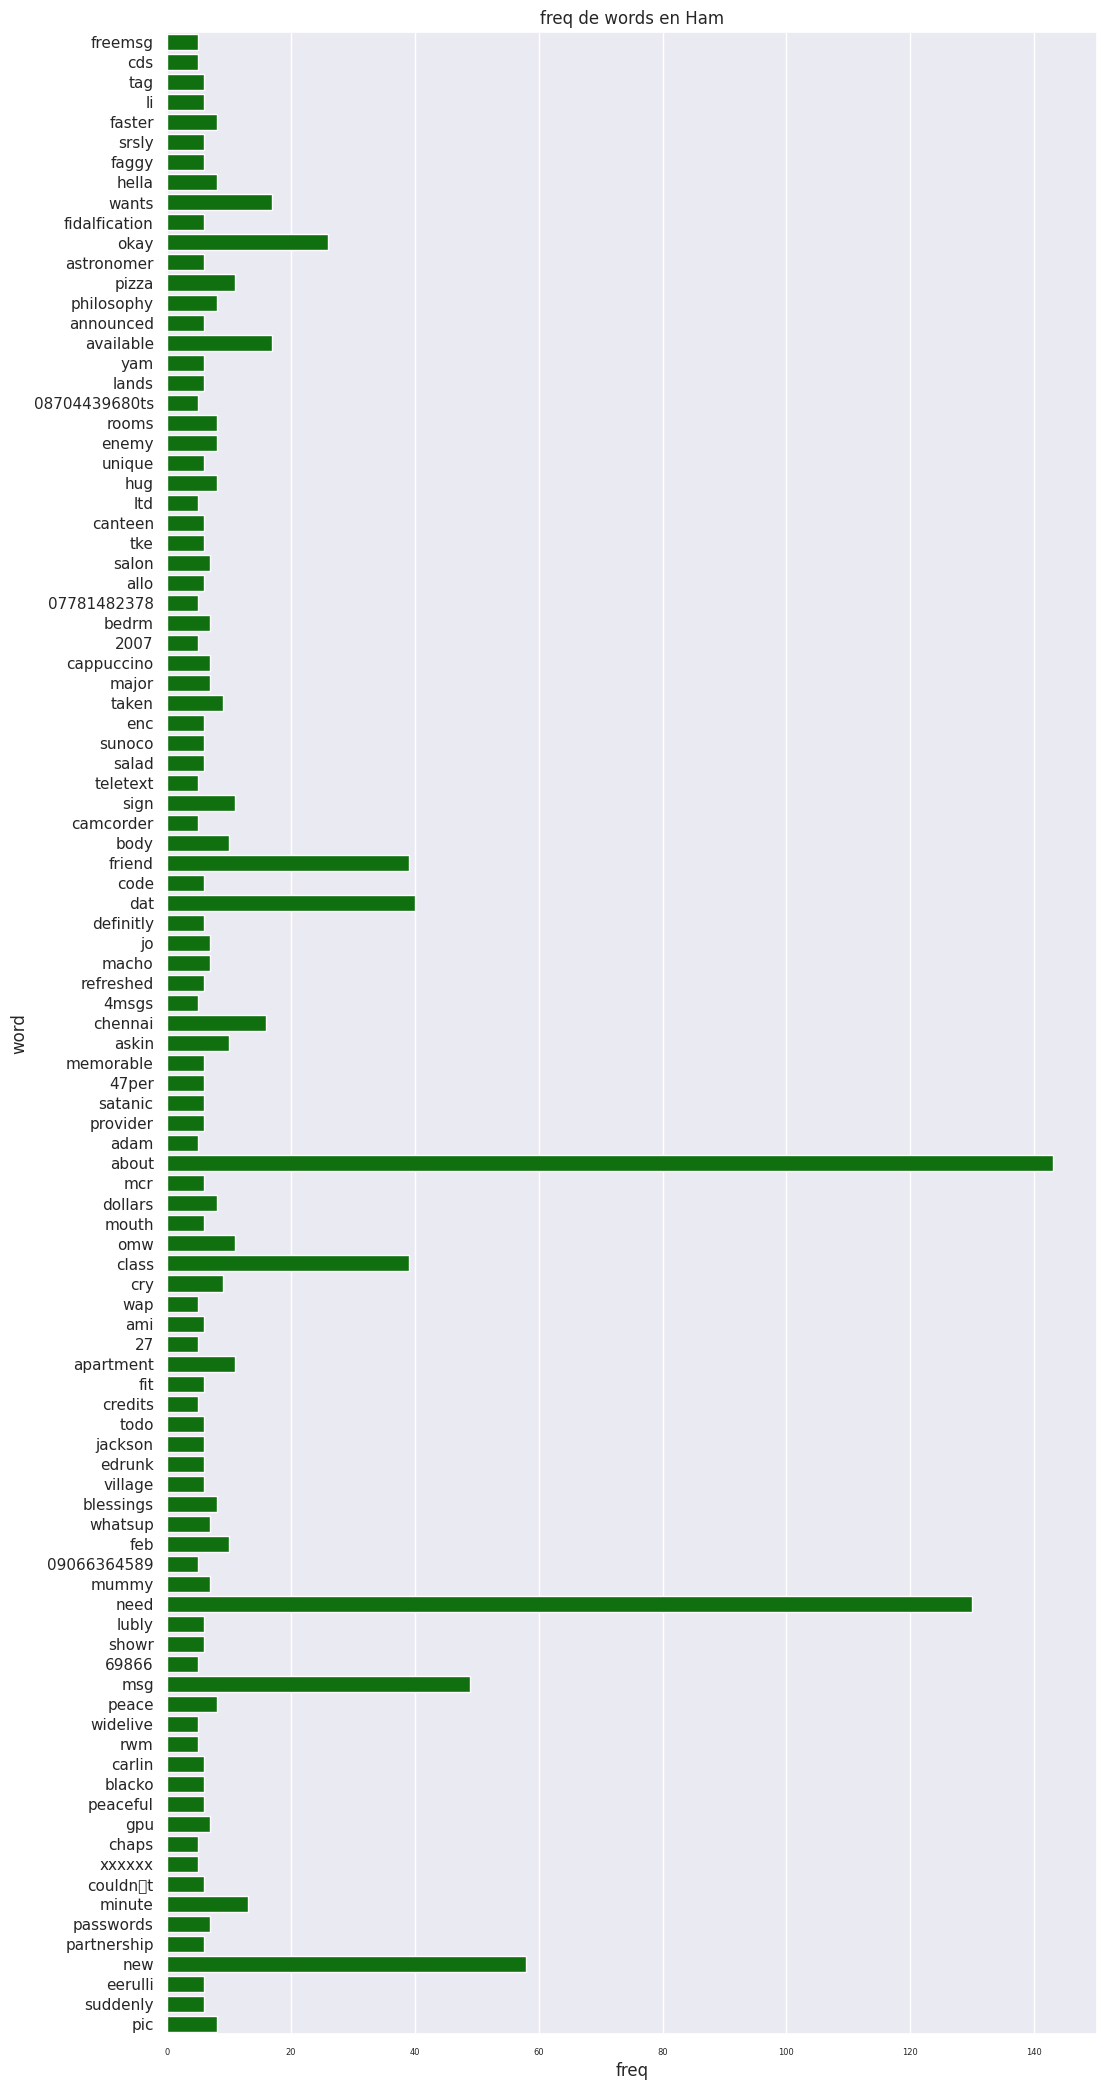

In [ ]:
# Spam
plt.figure(figsize=(12, 26))
sns.barplot(x=df['spam'], y=df.index, color='red')
plt.title('freq de words en Spam')
plt.xlabel('freq')
plt.ylabel('word')
plt.xticks(fontsize=6)
plt.show()

# Ham
plt.figure(figsize=(12, 26))
sns.barplot(x=df['ham'], y=df.index, color='green')
plt.title('freq de words en Ham')
plt.xlabel('freq')
plt.ylabel('word')
plt.xticks(fontsize=6)
plt.show()

## El alpha és el band width de les variables continues però per variables discretes.

## Ara fem una classe que ho generi, amb metodes:
- Fit
- Evaluate

Podríe fer soft classification: probabilitats per cada classe. Tornar dataframe amb la probabilitat de que sigui spam i una altre columna de que sigui ham.
<br />
<br />
Hard classification: la funció ens retornaria la que té superior probabilitat. dataframe on hi ha la predicció.
<br/>
<br/>
Després podem generalitzar de si passem les etiquetes son ham, spam, content trist, etc.
<br />
<br />
Haurem de fer un sentiment analysis classificats amb 6 classes. Hauría de ser un parametre de init i si vols tenen aquest nom.

In [ ]:
class NaiveBayes():
  dictionary = None
  n_ham = None
  n_spam = None
  prior = None

  def __init__(self):
    pass

  def init_dictionary(self, train_data):
    self.dictionary = {word: {'ham': 0, 'spam': 0} for word in list(set(train_data['tokens'].sum()))}

  def fit(self, train_data):
    self.init_dictionary(train_data)
    _ = train_data.apply(self.count_words, axis = 1)
    self.n_ham = sum([counts['ham'] for word, counts in self.dictionary.items()])
    self.n_spam = sum([counts['spam'] for word, counts in self.dictionary.items()])
    self.prior = train_data.Label.value_counts(normalize = True)

  def count_words(self, message):
    for word in message.tokens:
      self.dictionary[word][message.Label] +=1

  def ham_word_likelihood(self, word, alpha):
    if word in self.dictionary:
        return (self.dictionary[word]['ham'] + alpha) /(n_ham +(len(self.dictionary) *alpha))
    else:
        return 1

  def spam_word_likelihood(self, word, alpha):
    if word in self.dictionary:
        return (self.dictionary[word]['spam'] + alpha) /(n_spam +(len(self.dictionary) *alpha))
    else:
        return 1

  def eval_hard(self, test_data, alpha):
    test_data['predicted'] = test_data.tokens.apply(lambda x: self.classify(x, alpha))
    return test_data

  def eval_soft(self, test_data, alpha):
    test_data['is_ham'] = test_data.tokens.apply(lambda x: self.infer_is_ham(x, alpha))
    #test_data['is_spam'] = test_data.tokens.apply(lambda x: self.infer_is_spam(x, alpha))
    return test_data

  def eval_percentages(self, test_data, alpha):
    return pd.concat((test_data.groupby('Label').predicted.value_counts(), test_data.groupby('Label').predicted.value_counts(normalize = True)), axis = 1)

  def classify(self, tokens, alpha):
    post_ham, post_spam = prior
    for word in tokens:
        post_ham *= ham_word_likelihood(word, alpha)
        post_spam *= spam_word_likelihood(word, alpha)
    return 'spam' if post_spam > post_ham else ('ham' if post_ham > post_spam else '??')

  def infer_is_spam(self, tokens, alpha):
    post_spam = self.prior
    for word in tokens:
        post_spam *= spam_word_likelihood(word, alpha)
    return post_spam

  def infer_is_ham(self, tokens, alpha):
    post_ham = self.prior
    for word in tokens:
        post_ham *= ham_word_likelihood(word, alpha)
    return post_ham



Preparem les dades de nou:


In [ ]:
df = pd.read_csv(file_path, header=None, sep='\t', names=['Label', 'SMS'])

In [ ]:
df.head(2)

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [ ]:
df['tokens'] = df.SMS.apply(tokenize)

In [ ]:
X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 2873)

In [ ]:
classifyer = NaiveBayes()

In [ ]:
classifyer.fit(X_train)

In [ ]:
classifyer.prior

ham     0.869195
spam    0.130805
Name: Label, dtype: float64

In [ ]:
classifyer.eval_hard(X_test, alpha = 0)

,Label,SMS,tokens,predicted
4062,ham,"Aight I've been set free, think you could text...","[aight, i, ve, been, set, free, think, you, co...",ham
494,ham,What class of &lt;#&gt; reunion?,"[what, class, of, lt, gt, reunion]",ham
1396,ham,Thats cool! I am a gentleman and will treat yo...,"[thats, cool, i, am, a, gentleman, and, will, ...",ham
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,"[your, next, amazing, xxx, picsfree1, video, w...",ham
3120,ham,Stop knowing me so well!,"[stop, knowing, me, so, well]",ham
...,...,...,...,...
3346,ham,Reverse is cheating. That is not mathematics.,"[reverse, is, cheating, that, is, not, mathema...",ham
3542,ham,If you are not coughing then its nothing,"[if, you, are, not, coughing, then, its, nothing]",ham
5354,ham,Aiyo cos i sms ü then ü neva reply so i wait 4...,"[aiyo, cos, i, sms, ü, then, ü, neva, reply, s...",ham
3850,ham,U in town alone?,"[u, in, town, alone]",ham


In [ ]:
classifyer.eval_hard(X_test, 1)

,Label,SMS,tokens,predicted
4062,ham,"Aight I've been set free, think you could text...","[aight, i, ve, been, set, free, think, you, co...",ham
494,ham,What class of &lt;#&gt; reunion?,"[what, class, of, lt, gt, reunion]",ham
1396,ham,Thats cool! I am a gentleman and will treat yo...,"[thats, cool, i, am, a, gentleman, and, will, ...",ham
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,"[your, next, amazing, xxx, picsfree1, video, w...",ham
3120,ham,Stop knowing me so well!,"[stop, knowing, me, so, well]",ham
...,...,...,...,...
3346,ham,Reverse is cheating. That is not mathematics.,"[reverse, is, cheating, that, is, not, mathema...",ham
3542,ham,If you are not coughing then its nothing,"[if, you, are, not, coughing, then, its, nothing]",ham
5354,ham,Aiyo cos i sms ü then ü neva reply so i wait 4...,"[aiyo, cos, i, sms, ü, then, ü, neva, reply, s...",ham
3850,ham,U in town alone?,"[u, in, town, alone]",ham


In [ ]:
classifyer.eval_percentages(X_test, 1)

predicted  predicted
Label predicted                      
ham   ham              946   0.994742
      spam               4   0.004206
      ??                 1   0.001052
spam  spam             153   0.932927
      ham               11   0.067073

In [ ]:
classifyer.eval_soft(X_test, 0)

ValueError: Cannot set a DataFrame with multiple columns to the single column is_ham

In [ ]:
classifyer.eval_soft(X_test, 1)